# Analysis of facebook crawler

## 1. Needed libraries and functions, scroll down to section 2 for results

In [ ]:
#Some libraries we need
!pip install nltk
!pip install labMTsimple
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install numpy

### DOWNLOAD PACKAGE punkt from nltk (needed for stemming and tokenizing)
- Run next cell
- Download package from "all_packages"

In [55]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [11]:
#
import os
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

from collections import Counter
import pandas as pd
import pylab as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import entropy

#make nice plots
import seaborn as sns
sns.set(font_scale=1.2)
%matplotlib inline

#vocabulary from subtitles (take out all weird words, but keep some non-standard words). So far only Spanish!!


In [13]:
language = "es" #iso2 name of language (https://www.sitepoint.com/web-foundations/iso-2-letter-language-codes/)
path = "../data"
filename = "{}_full.txt".format(language)
if filename in os.listdir(path):
    with open("{}/{}".format(path,filename)) as f:
        set_words = set([_.split(" ")[0] for _ in f if int(_.split(" ")[1]) > 1])
    
else:
    import requests
    print("Downloading language")
    r = requests.get("https://github.com/hermitdave/FrequencyWords/raw/master/content/2016/{0}/{0}_full.txt".format(language))
    if not r.ok: print("That language doesn't exist")
    else:
        with open("{}/{}".format(path,filename),"w+") as f:
            f.write(r.text)

        with open("{}/{}".format(path,filename)) as f:
            set_words = set([_.split(" ")[0] for _ in f if int(_.split(" ")[1]) > 1])
        print("Ok")
    
    

In [155]:
def return_words(filename, sep="\t",stemming=True):
    """
    reads file and extract words and messages
    
    inputs:
    filename: path to file
    stemming: stem words
    
    returns list with all words from filename, and list of lists with messages (one list per line in file)
    """
    df = pd.read_csv(filename,sep="\t",header=None)
    
    messages = [[i for i in word_tokenize(text.lower()) if i in set_words] for text in df[6] if isinstance(text,str)]
    
    
    if stemming == True: 
        words = [stemmer.stem(w) for m in messages for w in m]
    else: 
        words = [w for m in messages for w in m]
        
    return words,messages


def merge_words(list_words_by_tag,list_tags = None):
    """
    create frequencies and merge several lists with words
    
    input:
    list_words_by_tag = list of lists with the words of each tag
    list_tags (default None) = name tags, if None then 0,1,2...
    
    output:
    dataframe with all words and its frequency in all groups
    list_tags
    """
    
    if list_tags is None: list_tags = range(len(list_words_by_tag))
    
    merged = pd.DataFrame()
    for words in list_words_by_tag:
        df = pd.DataFrame.from_dict(Counter(words),orient="index") 
        merged = pd.merge(merged,df,left_index=True,right_index=True,how="outer")
        
    merged.columns = list_tags
    return merged.fillna(0),list_tags

def get_prominence(merged_df,list_tags):
    """
    get top 100 significant words
    
    input:
    merged_df from merged_words() (frequencies of words)
    list_tags
    
    output:
    dataframe with top 100 most significant words
    """
    for tag in list_tags:
        #normalize frequencies
        merged_df[tag] = merged_df[tag]/np.sum(merged_df[tag])
    
    n_groups = len(list_tags)
    #calculate significance
    merged_df["expected"] = merged_df.loc[:,list_tags].sum(1)/n_groups
    merged_df["max_chi"] = (merged_df.loc[:,list_tags].subtract(merged_df["expected"], axis=0)**2).div(merged_df["expected"], axis=0).max(1)

    
    #calculate top_tag
    merged_df["top_tag"] = merged_df.loc[:,list_tags].idxmax(1)

    #keep the 100 most prominent and significant
    #merged_df_limit = merged_df.loc[merged_df["chi2"]>2E-5]
    #merged_df_limit = merged_df.loc[np.abs(50-merged_df["prom"])>20]
    
    merged_df_limit = merged_df.loc[merged_df["expected"] > 1E-5]
    merged_df_limit = merged_df_limit.sort_values(by="max_chi",ascending=False)
    merged_df_limit = merged_df_limit.iloc[:100]

    #sort by left prominence
    return merged_df_limit#.sort_values(by="perc_left",ascending=False)


def plot(merged_df_limit,list_tags,cmap="Set2",filename = None):
    """
    bar plot summing to 100% according to the left prominence (perc_left)
    
    input: 
    merged_df_limit from get_prominence()
    list_tags
    cmap: colormap to use
    filename: path to save the plot in. Default = don't save
    
    output:
    bar plot
    
    """
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    
    #colors (http://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib)
    NUM_COLORS = len(list_tags)

    cm = plt.get_cmap(cmap)
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    colors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

    #normalize to sum 100
    merged_df_limit.loc[:,list_tags] = 100*merged_df_limit.loc[:,list_tags].div(merged_df_limit.loc[:,list_tags].sum(1),axis=0)
    
    for tag,df in merged_df_limit.groupby("top_tag"):
        df = df.sort_values(by=tag,ascending=False)
        
        plt.figure(figsize=(15,1))
        i = 0
        
        for word,rest in df.iterrows():
            
            i += 1
            values = rest.loc[list_tags]
            cum_val = 0
            
            
            for j,value in enumerate(values):
                if i == 1:
                    plt.bar(i,value,bottom=cum_val,edgecolor="none",label=list_tags[j],color=colors[j])
                else:
                    plt.bar(i,value,bottom=cum_val,edgecolor="none",color=colors[j])
                cum_val += value
                
            
        plt.xticks(1.5+np.arange(df.shape[0]),df.index,rotation=90)
        plt.hlines(50,1,len(df)+1,color="white")
        plt.grid(False)
        plt.ylabel("Porcentaje de uso en diferentes grupos")
        legend = plt.legend(frameon=True)
        plt.ylim((0,100))
        if filename is not None: plt.savefig(filename+tag+".pdf")
        plt.show()

        
def study_coocur(merged_df_limit_iw,list_tags,list_messages_by_tag,threshold=0.4,filename = None): 
    """
    plots the dendrogram with the similarity between woords based on co-ocurrences
    input:
    merged_df_limit from get_prominence()
    list_tags
    list_messages_by_tag = list of lists with the messages of each tag
    threshold: threshold to separate dendrogram into groups
    filename: path to save the plot in. Default = don't save
    
    returns:    
    returns groups of similar words
    
    plots dendrogram
    
    """
    all_groups = []
    for tag,group in merged_df_limit_iw.groupby("top_tag"):
        i = list_tags.index(tag)
        vocab = list(group.index)
        mess = list_messages_by_tag[i]
        
        coocu = np.zeros((len(vocab),len(vocab)))
        for i,mes in enumerate(mess):
            for i1,w1 in enumerate(vocab):
                if w1 in mes:
                    for i2,w2 in enumerate(vocab[i1+1:]):
                        if w2 in mes:
                            coocu[i1,i2+i1+1] += 1

        vals = []
        for i in range(len(vocab)):
            for j in range(i+1,len(vocab)):
                vals.append(1./(1+coocu[i,j]))

        data_dist = vals

        #print(data_dist)
        fig = plt.figure(figsize=(6,12))

        # plot first dendrogram:
        ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
        Y = linkage(data_dist, method='weighted') # method?

        t = max(Y[:, 2]) * threshold
        Z1 = dendrogram(Y, orientation='right',
                    leaf_font_size=12,color_threshold=t,labels=vocab) # adding/removing the axes
                    #labels=["Profit","Decay","Profit \n(Ratio)","IMDB rating","Metascore","RottenT \nAudience","RottenT \nCritics","Profit \n(Deviation)"],
        ax1.set_xticks([]) # turn off xticks

        plt.grid(False)
        if filename is not None: plt.savefig(filename+tag)
        plt.show()
        
        groups = []
        for i,g in pd.DataFrame.from_dict(dict(zip(Z1["ivl"],Z1["color_list"])),orient="index").groupby(0):
            if  i != "b":
                groups.append(list(g.index))
            else:
                for _ in g.index:
                    groups.append(_)
        all_groups.append(groups)
    return all_groups

## 2. Extract messages and words

In [16]:
#All real words in the two groups
left_words,left_messages = return_words("../data/left_comments.txt",stemming=True)
right_words,right_messages = return_words("../data/right_comments.txt",stemming=True)

list_words_by_tag = [left_words,right_words]
#All real words in each comment (one string per comment)
left_mess = [" ".join(lm) for lm in left_messages]
right_mess = [" ".join(rm) for rm in right_messages]
list_messages_by_tag = [left_mess,right_mess]

## 3. Look at individual words

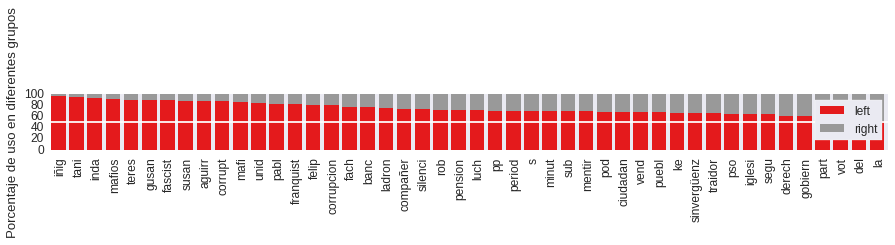

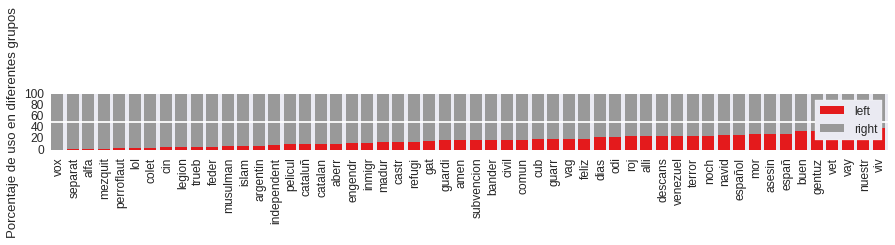

In [156]:
#merge by word
merged_df_iw,list_tags = merge_words(list_words_by_tag,list_tags=["left","right"])
#get top words
merged_df_limit_iw = get_prominence(merged_df_iw,list_tags)
#make plots
plot(merged_df_limit_iw,list_tags,"Set1")

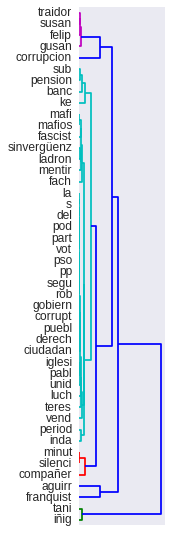

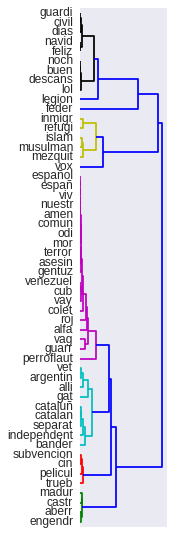

In [159]:
#make dendrograms
all_groups = study_coocur(merged_df_limit_iw,list_tags,list_messages_by_tag,0.2)

## 4. Look at groups of three words

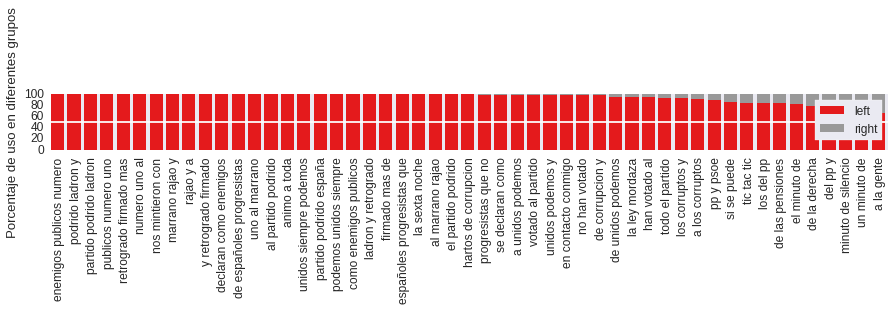

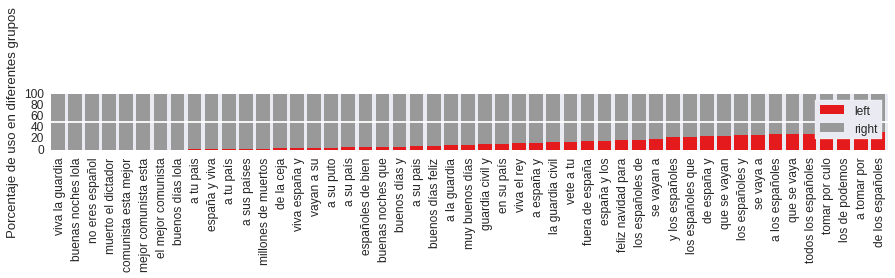

In [160]:
#trigrams
left_trigrams = [" ".join(lm[i:i+3]) for lm in left_messages for i in range(len(lm)-3)]
right_trigrams = [" ".join(lm[i:i+3]) for lm in right_messages for i in range(len(lm)-3)]
list_trigrams_by_tag = [left_trigrams,right_trigrams]
merged_df_tri,list_tags = merge_words(list_trigrams_by_tag,list_tags=["left","right"])
merged_df_limit_tri = get_prominence(merged_df_tri,list_tags)
plot(merged_df_limit_tri,list_tags,"Set1")

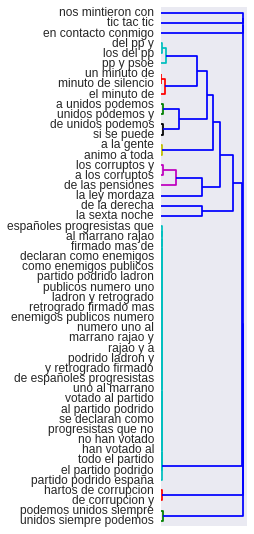

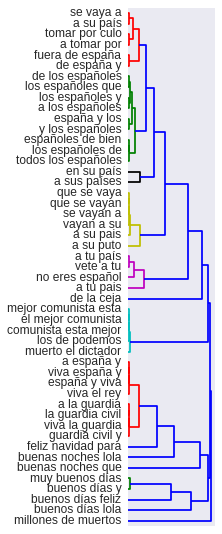

In [161]:
all_groups = study_coocur(merged_df_limit_tri,list_tags,list_messages_by_tag,0.2)

## 5. Trigrams that give you likes (temp)

In [54]:
from collections import defaultdict
d = defaultdict(int)
d_likes = defaultdict(int)
with open("../data/left_comments.txt") as f:
    for line in f:
        data,like_number,user,*message = line[1:-1].split(" ")
        #delete no workds
        message = [_ for _ in message if _ in set_words]
        #trigrams = [" ".join(message[i:i+3]) for i in range(len(message)-3)]
        
        
        for l in message:
            d[l] += 1
            d_likes[l] += int(like_number)
        

In [55]:
df_likes_raw = pd.merge(pd.DataFrame.from_dict(d,orient="index"),pd.DataFrame.from_dict(d_likes,orient="index"),left_index=True,right_index=True)
df_likes_raw.columns = ["base","likes"]

In [59]:
df_likes = df_likes_raw.loc[df_likes_raw["base"]>10]
df_likes["likes"] /= np.sum(df_likes["likes"])
df_likes["likes"] *= np.sum(df_likes["base"])


#calculate significance
df_likes["chi2"] = (df_likes["likes"]-df_likes["base"])**2/df_likes["base"]


#calculate left prominence
df_likes["log_ratio_likes"] = (df_likes["likes"]/df_likes["base"])
df_likes = df_likes.loc[df_likes["log_ratio_likes"]>1]
df_likes.sort_values(by="chi2",ascending=False)

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,base,likes,chi2,log_ratio_likes
silencio,576,1364.164227,1.078477e+03,2.368341
minuto,803,1581.168628,7.541051e+02,1.969077
mintieron,101,300.173488,3.927731e+02,2.972015
y,72318,76032.797353,1.908200e+02,1.051368
respeto,683,984.645518,1.332211e+02,1.441648
guardar,128,255.243061,1.264906e+02,1.994086
homenaje,130,258.110961,1.262494e+02,1.985469
víctimas,115,235.167764,1.255678e+02,2.044937
copiar,16,58.313958,1.119044e+02,3.644622
estrellas,45,112.804050,1.021642e+02,2.506757


In [ ]:
merged_df_limit_iw = get_prominence(merged_df_iw)